In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
df = pd.read_csv("data.csv")
df

,week,volume
0,2022-10-31,0.33
1,2022-11-07,0.47
2,2022-11-14,0.32
3,2022-11-21,1.69
4,2022-11-28,1.23
...,...,...
145,2025-08-11,13.60
146,2025-08-18,15.20
147,2025-08-25,16.24
148,2025-09-01,13.43


In [4]:
# Extrai o ano da coluna week e conta registros por ano
df["week"] = pd.to_datetime(df["week"])
df["year"] = df["week"].dt.year
df["year"].value_counts().sort_index()

year
2022     9
2023    52
2024    53
2025    36
Name: count, dtype: int64

OBS: Temos poucos dados para 2022 em comparação com os outros anos

In [5]:
anos = df["week"].dt.year.unique()

locs = []
for ano in anos:
    primeira_data = df[df["week"].dt.year == ano]["week"].iloc[0]
    locs.append(primeira_data)

locs

[Timestamp('2022-10-31 00:00:00'),
 Timestamp('2023-01-02 00:00:00'),
 Timestamp('2024-01-01 00:00:00'),
 Timestamp('2025-01-06 00:00:00')]

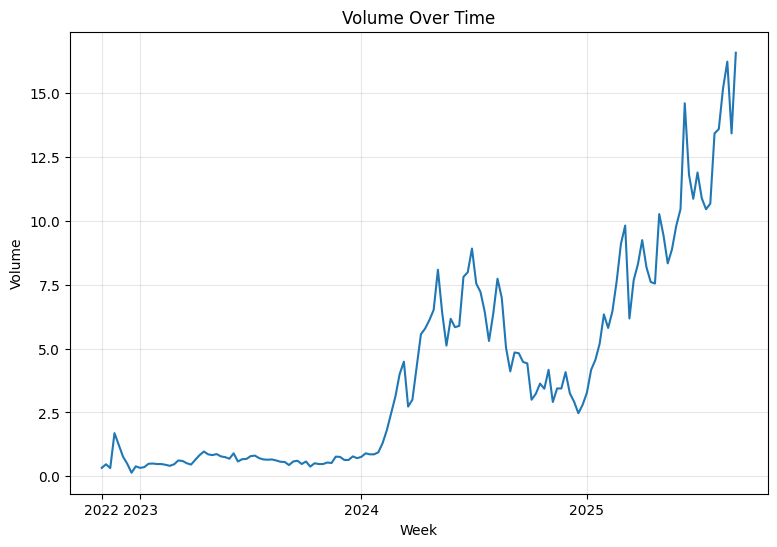

In [6]:
plt.figure(figsize=(9, 6))
sns.lineplot(df, x="week", y="volume")
plt.xticks(locs, anos)
plt.xlabel("Week")
plt.ylabel("Volume")
plt.title("Volume Over Time")
plt.grid(True, alpha=0.3)

De 2022 até o início de 2024, o volume fica relativamente baixo e estável. A partir de 2024, há um crescimento bem visível, com aceleração em 2025.

Isso pode indicar heterocedasticidade (a variância aumenta com o tempo).

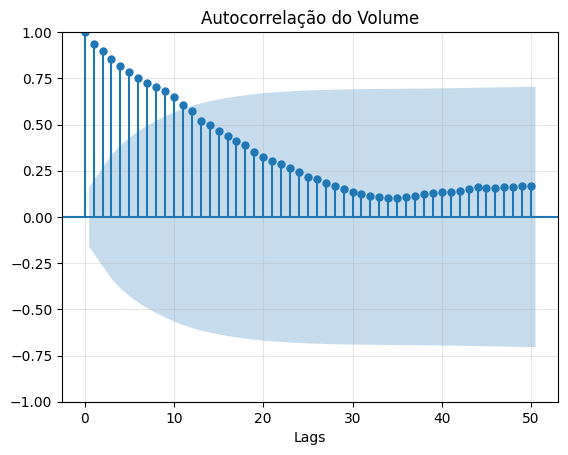

In [24]:
# Verificando autocorrelação entre as observações
plot_acf(df["volume"], lags=50)
plt.xlabel("Lags")
plt.title("Autocorrelação do Volume")
plt.grid(True, alpha=0.3)

A ACF começa muito alta nos primeiros lags, com valores próximos de 1. Ela vai decrescendo devagar até perto de 30 lags.

Esse decaimento lento indica uma tendência forte na série (não é estacionária).

Depois de uns 30 lags, os valores ficam bem próximos de zero, dentro da faixa azul (intervalo de confiança de 95%), ou seja, pouca evidência de autocorrelação de longo prazo.

Dessa forma, há uma forte dependência temporal nas observações do volume.

Com o objetivo de estabilizar a variância, vamos aplicar agora algumas transformações, como: log e Box-Cox.

In [33]:
# Transformações para estabilizar a variância

# Log
df["log_volume"] = np.log(df["volume"]+1)  # Adiciona 1 para evitar log(0)

# Box-Cox
df["volume_boxcox"], lambda_bc = boxcox(df['volume']+1)  # Adiciona 1 para evitar valores <= 0
print(lambda_bc)

-0.18640389562576232


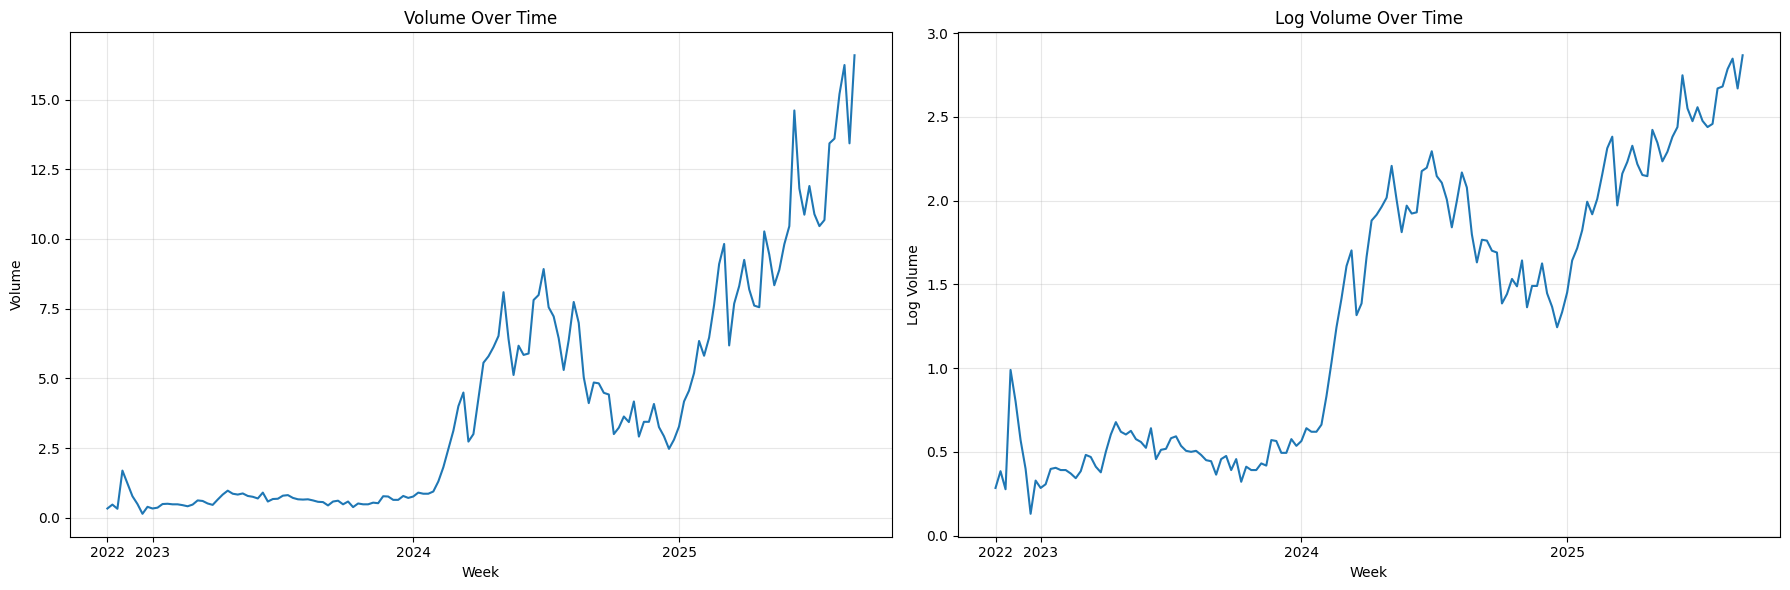

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico da esquerda - Volume
sns.lineplot(df, x="week", y="volume", ax=ax1)
ax1.set_xticks(locs)
ax1.set_xticklabels(anos)
ax1.set_xlabel("Week")
ax1.set_ylabel("Volume")
ax1.set_title("Volume Over Time")
ax1.grid(True, alpha=0.3)

# Gráfico da direita - Log Volume
sns.lineplot(df, x="week", y="log_volume", ax=ax2)
ax2.set_xticks(locs)
ax2.set_xticklabels(anos)
ax2.set_xlabel("Week")
ax2.set_ylabel("Log Volume")
ax2.set_title("Log Volume Over Time")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

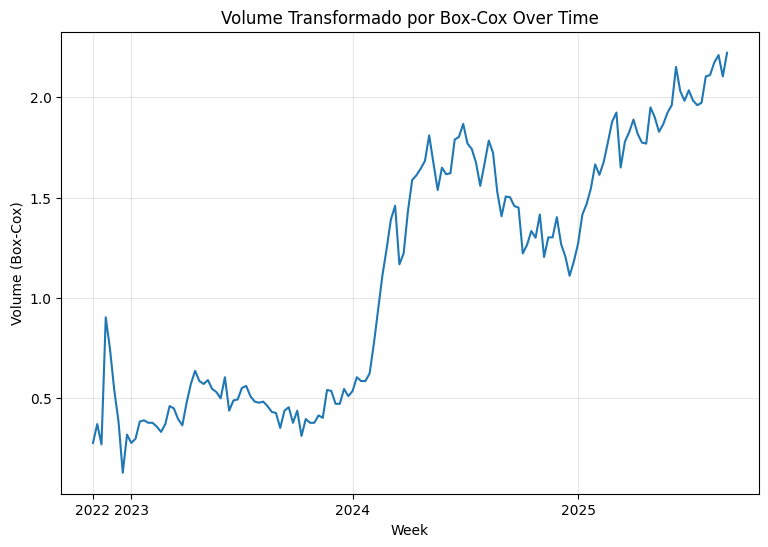

In [29]:
plt.figure(figsize=(9, 6))
sns.lineplot(df, x="week", y="volume_boxcox")
plt.xticks(locs, anos)
plt.xlabel("Week")
plt.ylabel("Volume (Box-Cox)")
plt.title("Volume Transformado por Box-Cox Over Time")
plt.grid(True, alpha=0.3)
plt.show()

Observe que não houve diferença em aplicar o Box-Cox e o Log. Isso ocorre porque lambda é aproximadamente -0.18, um valor bem próximo de 0, que torna o Box-Cox equivalente ao Log.

Como a série ainda mostra tendência, precisamos aplicar diferenças, como a diferença simples e a com log

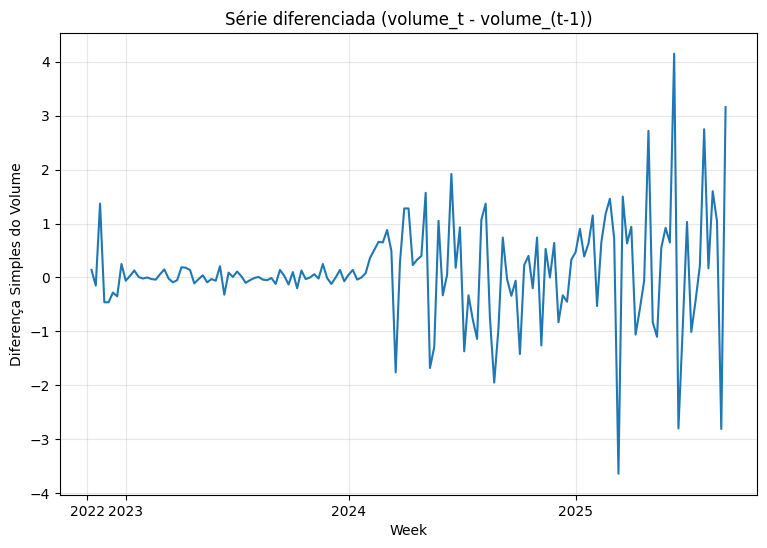

In [ ]:
# Diferença simples
df['diff_volume'] = df['volume'].diff()

plt.figure(figsize=(9, 6))
sns.lineplot(df, x="week", y="diff_volume")
plt.xticks(locs, anos)
plt.xlabel("Week")
plt.ylabel("Diferença Simples do Volume")
plt.title("Série diferenciada (volume_t - volume_(t-1))")
plt.grid(True, alpha=0.3)
plt.show()

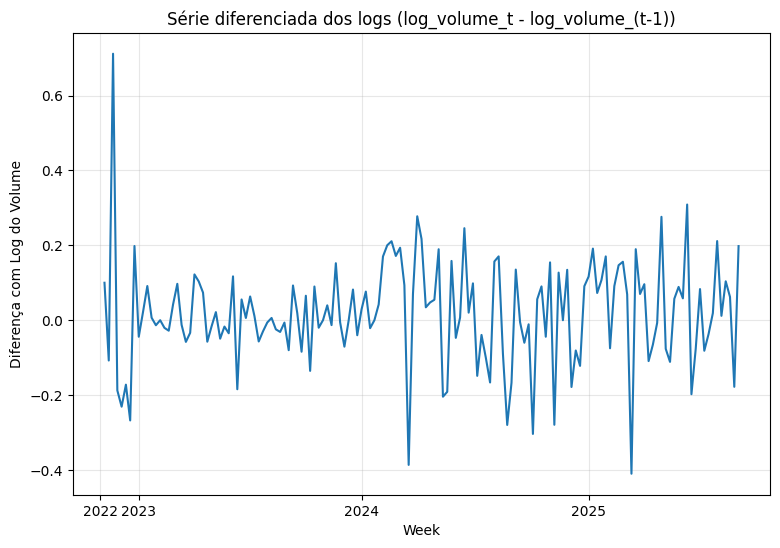

In [31]:
# Diferença com log
df['diff_log_volume'] = df['log_volume'].diff()

plt.figure(figsize=(9, 6))
sns.lineplot(df, x="week", y="diff_log_volume")
plt.xticks(locs, anos)
plt.xlabel("Week")
plt.ylabel("Diferença com Log do Volume")
plt.title("Série diferenciada dos logs (log_volume_t - log_volume_(t-1))")
plt.grid(True, alpha=0.3)
plt.show()

Verificando se a série já ficou estacionária com ACF

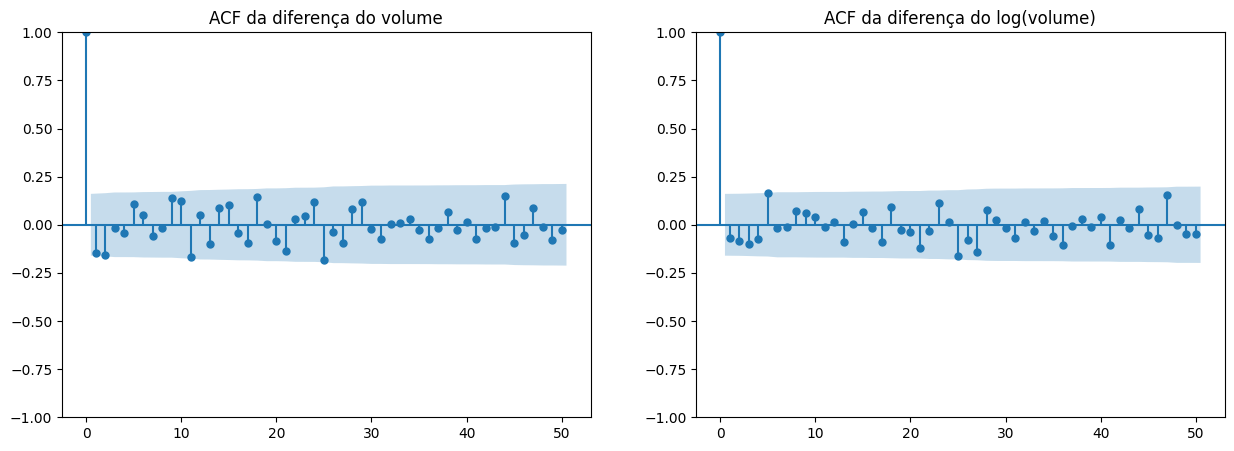

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

plot_acf(df['diff_volume'].dropna(), lags=50, ax=axes[0])
axes[0].set_title("ACF da diferença do volume")

plot_acf(df['diff_log_volume'].dropna(), lags=50, ax=axes[1])
axes[1].set_title("ACF da diferença do log(volume)")

plt.show()

Ambas as transformações levaram a uma série estacionária, mas em geral a diferença do log(volume) estabiliza melhor a variância.